- Gaussian Mixture Model: SVGD v GSVGD vs HMC vs IAF flow
- Bayesian logistic regression: HMC v IAF Flow v
- Bayesian neural network
- Variational GP regression 

In [1]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import pandas as pd
import torch
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import MultivariateNormal
import torch.distributions as D
# from pymanopt.manifolds import Grassmann
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import sys
sys.path.append("..")
from src.manifold import Grassmann

from src.utils import get_density_chart, get_particles_chart

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

from src.svgd import SVGD
from src.gsvgd import GSVGD
from src.kernel import RBF
from src.metrics import mmd_rbf

In [2]:
device

device(type='cpu')

## Multivariate Gaussian

$$q(x) = \mathcal{N}(x;\mu, \Sigma)$$
where $\Sigma \in \mathbb{R}^{d \times d}$, and $s$ of the $d$ dimensions are highlly correlated ($\approx 1$).

Calculate $\mathbb{E}_q[X]$ using
- SVGD
- G-SVGD with Grassmanian($d, s$). The matrix $A$ is initialized as the first $s$ columns of $I_d$.

In [3]:
def low_effective_dim_gaussian(
    dim: int, 
    eff_dim: int, 
    jitter: float, 
    rotation: np.ndarray, 
    mean: torch.Tensor,
    device="cpu"
) -> torch.distributions:
    '''
        eff_dim: Effective dim, with unit var in the original space.
        rotation: Rotation matrix to be applied to 
    '''
    cov = torch.eye(dim)
    cov[eff_dim:, eff_dim:] = torch.eye(dim-eff_dim) * np.sqrt(jitter)
    
    rotation = torch.Tensor(rotation)
    rotated_cov = (rotation @ cov @ rotation.t()).detach()
    distribution = torch.distributions.MultivariateNormal(
        (rotation @ mean).to(device),
        rotated_cov.to(device)
    )
    return(distribution)

def low_effective_dim_gaussian_1(
    dim: int, 
    eff_dim: int, 
    jitter: float, 
    rotation: np.ndarray, 
    mean: torch.Tensor,
    device="cpu"
) -> torch.distributions:
    '''
        eff_dim: Effective dim, with unit var in the original space.
        rotation: Rotation matrix to be applied to 
    '''
    cov = torch.eye(dim)
    cov[eff_dim:, eff_dim:] = torch.eye(dim-eff_dim) * np.sqrt(jitter)
    
    rotation = torch.Tensor(rotation)
    rotated_cov = (rotation @ cov @ rotation.t()).detach()
    distribution = torch.distributions.MultivariateNormal(
        (rotation @ mean)[:eff_dim].to(device),
        (rotated_cov)[:eff_dim, :eff_dim].to(device)
    )
    return(distribution)



In [4]:
from scipy.stats import special_ortho_group

dim = 100
jitter = 1e-4
eff_dim = 2
mean_vec = torch.Tensor([0] * dim) 
mean_vec[:] = 2

# rotation = special_ortho_group.rvs(dim)
rotation = torch.eye(dim)
print(rotation.T @ rotation) # should give identity matrix

distribution = low_effective_dim_gaussian(
    dim=dim,
    eff_dim=eff_dim,
    jitter=jitter,
    rotation=rotation,
    mean=mean_vec,
    device=device
)

distribution_low = low_effective_dim_gaussian_1(
    dim=dim,
    eff_dim=eff_dim,
    jitter=jitter,
    rotation=rotation,
    mean=mean_vec,
    device=device
)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

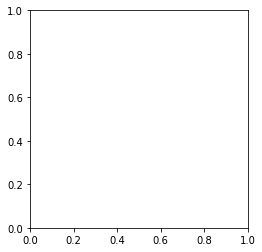

In [5]:
plt.imshow(distribution.covariance_matrix)
plt.colorbar()

In [ ]:
plt.imshow(distribution.covariance_matrix[:eff_dim + 2, :eff_dim + 2])
plt.colorbar()

(-1.0, 5.0)

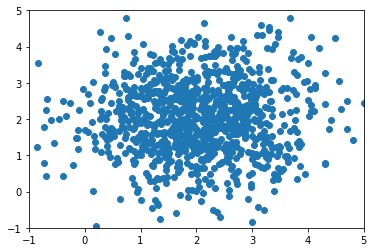

In [8]:
# sanity check
xx = distribution.sample((1000,)).detach().numpy()
# rotated_xx = xx @ np.linalg.inv(rotation).T
rotated_xx = xx @ np.linalg.inv(rotation).T
# print(pd.DataFrame(rotated_xx).cov())
plt.scatter(rotated_xx[:, 0], rotated_xx[:, 1])
plt.xlim((mean_vec[0] - 3, mean_vec[0] + 3))
plt.ylim((mean_vec[0] - 3, mean_vec[0] + 3))

(-1.0, 5.0)

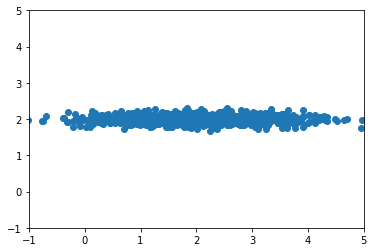

In [9]:
# sanity check
xx = distribution.sample((1000,)).detach().numpy()
rotated_xx = xx @ np.linalg.inv(rotation).T
# print(pd.DataFrame(rotated_xx).cov())
plt.scatter(rotated_xx[:, 0], rotated_xx[:, eff_dim])
plt.xlim((mean_vec[0] - 3, mean_vec[0] + 3))
plt.ylim((mean_vec[0] - 3, mean_vec[0] + 3))

# SVGD

In [6]:
repetitions = 1

In [8]:
## SVGD
num_particles = 5000
lr = 1e-2
epochs = 2000

torch.manual_seed(0)

est_SVGD = []
loglkhd_SVGD = []
samples_SVGD = []
for r in tqdm(range(repetitions)):
    
    # sample from variational density
    x_init = torch.randn(num_particles, *distribution.event_shape)
    x = x_init.clone().to(device)
    kernel = RBF(sigma=1, method="nah")
    svgd = SVGD(distribution, kernel, optim.Adam([x], lr=lr))
    svgd.fit(x, epochs, verbose=True)
        
    # store samples
    samples_SVGD.append(x)
    # mean estimate
    est = np.mean(x.numpy(), axis=0)
    est_SVGD.append(est)
    # loglikelihood
    loglkhd = distribution.log_prob(x.detach()).mean()
    loglkhd_SVGD.append(loglkhd)
    
# print("SVGD MSE:", np.mean(np.sum((est_SVGD - mean.numpy()) ** 2, axis=1)))
print("SVGD mean loglikelihood:", np.mean(loglkhd_SVGD))

  0%|          | 0/1 [00:00<?, ?it/s]


 40%|████      | 805/2000 [00:10<00:15, 76.21it/s]


KeyboardInterrupt: 

In [ ]:
# sanity check for low eff-dim experiment
ind1, ind2 = 0, 1
xx = x
rotated_xx = xx @ np.linalg.inv(rotation).T
rotated_xinit = x_init @ np.linalg.inv(rotation).T
print(pd.DataFrame(rotated_xx).cov())
plt.scatter(rotated_xx[:, ind1], rotated_xx[:, ind2], label="final")
plt.scatter(rotated_xinit[:, ind1], rotated_xinit[:, ind2], color="red", label="initial")
plt.legend()
plt.xlim((-6, 6))
plt.ylim((-6, 6))

In [ ]:
# loglkhd_SVGD = []
for x in samples_SVGD:
    loglkhd = distribution.log_prob(x.detach()).sum()
    loglkhd_SVGD.append(loglkhd)

print("SVGD mean loglikelihood:", np.mean(loglkhd_SVGD))

In [ ]:
loglkhd_SVGD = []
for x in samples_SVGD:
    loglkhd = distribution.log_prob(x.detach()).sum()
    loglkhd_SVGD.append(loglkhd)

print("SVGD mean loglikelihood:", np.mean(loglkhd_SVGD))

In [ ]:
# transforming back to original coords
xx = samples_SVGD[0].detach()
xx_transformed = xx @ np.linalg.inv(rotation).T
plt.scatter(xx_transformed[:, 0], xx_transformed[:, -1])
plt.xlim((mean_vec[0] - 3, mean_vec[0] + 3))
plt.ylim((mean_vec[0] - 3, mean_vec[0] + 3))

# G-SVGD

In [7]:
torch.distributions.Normal(torch.zeros(1), torch.ones(1)).mean

tensor([0.])

In [8]:
torch.distributions.Normal(torch.zeros(100).to(device), torch.(1).to(device)).sample((10,2)).shape

SyntaxError: invalid syntax (<ipython-input-8-30210fed5ad3>, line 1)

In [9]:
import sys
from src.kernel import RBF
from src.gsvgd import GSVGD
repetitions = 1
num_particles = 5000
lr = 1e-2
epochs = 5000

torch.manual_seed(0)

est_GSVGD = [0] * repetitions
loglkhd_GSVGD = [0] * repetitions
samples_GSVGD = [0] * repetitions
for r in tqdm(range(repetitions)):
    
    # sample from variational density
    x_init = torch.randn(num_particles, *distribution.event_shape)
    x = x_init.clone().to(device)
    
    kernel = RBF(method="nah", sigma=1, device=device)
    optimizer = optim.Adam([x], lr=1e-2)
    manifold = Grassmann(dim, eff_dim)
    A = torch.eye(dim)[:, :eff_dim].requires_grad_(True).to(device)

    gsvgd = GSVGD(
        target=distribution,
        kernel=kernel,
        manifold=manifold,
        optimizer=optimizer,
        delta=0.01,
        device=device
    )
    
    A = gsvgd.fit(x, A, epochs, verbose=True)
        
    # store samples
    samples_GSVGD[r] = x.clone().numpy()
    # loglikelihood
    loglkhd_GSVGD[r] = distribution.log_prob(x.detach()).mean()
    
# print("G-SVGD MSE:", np.mean(np.sum((est_GSVGD - mean.numpy()) ** 2, axis=1)))
print("GSVGD mean loglikelihood:", np.mean(loglkhd_GSVGD))

  0%|          | 0/1 [00:00<?, ?it/s]


  3%|▎         | 148/5000 [00:20<10:58,  7.37it/s]


KeyboardInterrupt: 

In [ ]:
# sanity check
ind1, ind2 = 0, 1

xx = x
rotated_xx = xx @ np.linalg.inv(rotation).T
rotated_xinit = x_init @ np.linalg.inv(rotation).T
print(pd.DataFrame(rotated_xx).cov())
plt.scatter(rotated_xx[:, ind1], rotated_xx[:, ind2], label="final")
plt.scatter(rotated_xinit[:, ind1], rotated_xinit[:, ind2], color="red", label="initial")
plt.legend()
plt.xlim((-6, 6))
plt.ylim((-6, 6))

# Multimodal Mixture of Gaussian (SVGD)

In [35]:
def mix_gauss_experiment(mixture_dist, means):
    '''Mixture of Multivariate gaussian with cov matrices being the identity.
    Args:
        probs: Tensor of shape (nmix,) for the mixture_distribution.
        means: Tensor of shape (nmix, d), where nmix is the number of components 
            and d is the dimension of each component.
    '''
    nmix = means.shape[0]
    comp = D.Independent(D.Normal(means, torch.ones((nmix, means.shape[1]))), 1)
    distribution = D.mixture_same_family.MixtureSameFamily(mixture_dist, comp)    
    return(distribution)

def points_on_circle(theta, rad):
    return(torch.Tensor([[rad * np.cos(theta), rad * np.sin(theta)]]))

In [38]:
nmix = 6
dim = 3

mix_means = torch.cat(
    [points_on_circle(i * 2*np.pi / nmix, rad=5) for i in range(nmix)])
mix_means = torch.cat((mix_means, torch.zeros((mix_means.shape[0], dim - 2))), dim=1)
num_particles = 50
lr = 1e-2
epochs = 100

distribution = mix_gauss_experiment(
    mixture_dist=D.Categorical(torch.ones(mix_means.shape[0],)),
    means=mix_means
)

# sample from target (for computing metric)
x_target = distribution.sample((nparticles, ))

# sample from variational density
x_init = torch.randn(nparticles, *distribution.event_shape)
x = x_init.clone().to(device)
kernel = RBF(sigma=1, method="nah")
svgd = SVGD(distribution, kernel, optim.Adam([x], lr=lr))
metric_svgd = svgd.fit(x, epochs, verbose=True, metric=lambda y: mmd_rbf(y, x_target.detach()))


100%|██████████| 100/100 [00:00<00:00, 168.72it/s]


In [40]:
fig = get_density_chart(distribution, d=10.0, step=0.2)
fig = (fig + get_particles_chart(x_init.cpu().numpy())) | (
    fig + get_particles_chart(x.cpu().numpy())
)
fig

Concatenating higher dims with vector of zeros. Customize by using the concat argument.


alt.HConcatChart(...)

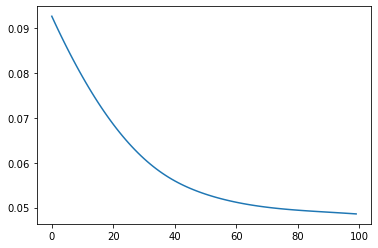

In [42]:
plt.plot(range(len(metric_svgd)), metric_svgd)

# X-shaped Multi-modal Gaussian (SVGD)

In [3]:
def xshaped_gauss_experiment(mixture_dist, means, correlation, nparticles, lr, epochs):
    '''Mixture of Multivariate gaussian with cov matrices being the identity.
    Args:
        mixture_dist: torch.distributions.Categorical-like instance for the 
            probability of each component in the mixture.
        means: Tensor of shape (nmix, d), where nmix is the number of components 
            and d is the dimension of each component.
        correlation: Float between 0 and 1 for the magnitude of correlation between
            the first two dims.
    '''
    nmix, dim = means.shape
    
    # create multibatch multivariate Gaussian
    cov1 = torch.eye(dim)
    cov1[:2, :2] = torch.Tensor([[1, correlation], [correlation, 1]])
    cov2 = torch.eye(dim)
    cov2[:2, :2] = torch.Tensor([[1, -correlation], [-correlation, 1]])
    mix_cov = torch.stack((cov1, cov2))
    comp = D.MultivariateNormal(means, mix_cov)

    distribution = D.mixture_same_family.MixtureSameFamily(mixture_dist, comp)   
    return(distribution)

In [4]:
dim = 2
correlation = 0.95
nparticles = 500
lr = 1e-2
epochs = 1000

mix_means = torch.zeros((2, dim))

distribution = xshaped_gauss_experiment(
    mixture_dist=D.Categorical(torch.ones(mix_means.shape[0],)),
    means=mix_means,
    correlation=correlation,
    nparticles=nparticles,
    lr=lr,
    epochs=epochs
)

# sample from target (for computing metric)
x_target = distribution.sample((nparticles, ))

# sample from variational density
x_init = torch.randn(nparticles, *distribution.event_shape)
x = x_init.clone().to(device)
kernel = RBF(sigma=1, method="nah")
svgd = SVGD(distribution, kernel, optim.Adam([x], lr=lr))
metric_svgd = svgd.fit(x, epochs, verbose=True, metric=lambda y: mmd_rbf(y, x_target.detach()))


100%|██████████| 1000/1000 [00:32<00:00, 30.40it/s]


In [78]:
fig = get_density_chart(distribution, d=5.0, step=0.1, concat=mix_means[0, 2:])
fig = (fig + get_particles_chart(x_init.cpu().numpy())) | (
    fig + get_particles_chart(x.cpu().numpy())
)
fig

alt.HConcatChart(...)

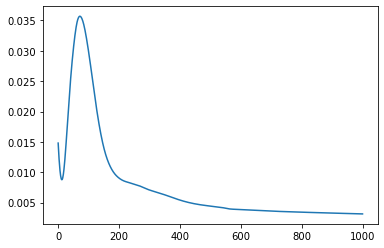

In [79]:
plt.plot(range(len(metric_svgd)), metric_svgd)

In [1]:
## GSVGD
eff_dim = 2 # dim - 2

torch.manual_seed(0)
# sample from variational density
x_init_gsvgd = torch.randn(nparticles, *distribution.event_shape)
x_gsvgd = x_init_gsvgd.clone().to(device)

kernel = RBF(method="nah", sigma=1)
optimizer = optim.Adam([x_gsvgd], lr=lr)
manifold = Grassmann(dim, eff_dim)
A = torch.eye(dim)[:, :eff_dim].requires_grad_(True)

gsvgd = GSVGD(
    target=distribution,
    kernel=kernel,
    manifold=manifold,
    optimizer=optimizer,
    delta=0.1
)
A, metric_gsvgd = gsvgd.fit(x_gsvgd, A, epochs, verbose=True, 
    metric=lambda y: mmd_rbf(y, x_target.detach()))

NameError: name 'torch' is not defined

In [ ]:
A

In [81]:
fig = get_density_chart(distribution, d=5.0, step=0.1, concat=mix_means[0, 2:])
fig = (fig + get_particles_chart(x_init_gsvgd.cpu().numpy())) | (
    fig + get_particles_chart(x_gsvgd.cpu().numpy())
)
fig

alt.HConcatChart(...)

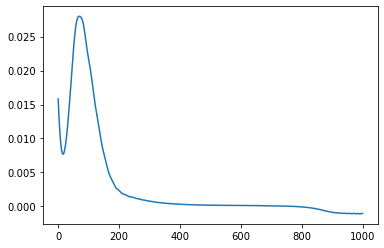

In [82]:
plt.plot(range(len(metric_gsvgd)), metric_gsvgd)

In [33]:
import os
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.distributions import MultivariateNormal
import torch.distributions as D
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import sys
sys.path.append("..")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from src.svgd import SVGD
from src.gsvgd import GSVGD
from src.kernel import RBF
from src.utils import get_density_chart, get_particles_chart, plot_particles
from src.metrics import mmd_rbf
from src.kldivergence import kldivergence
from src.manifold import Grassmann

import pickle

import argparse


def mix_gauss_experiment(mixture_dist, means):
    '''Mixture of Multivariate gaussian with cov matrices being the identity.
    Args:
        probs: Tensor of shape (nmix,) for the mixture_distribution.
        means: Tensor of shape (nmix, d), where nmix is the number of components 
            and d is the dimension of each component.
    '''
    nmix = means.shape[0]
    comp = D.Independent(D.Normal(means.to(device), torch.ones((nmix, means.shape[1])).to(device)), 1)
    distribution = D.mixture_same_family.MixtureSameFamily(mixture_dist, comp) 
    return(distribution)


def points_on_circle(theta, rad):
    '''Generate d-dim points whose first two dimensions lies on a circle of 
    radius rad, with position being specified by the angle from the positive 
    x-axis theta.
    '''
    return(torch.Tensor([[rad * np.cos(theta), rad * np.sin(theta)]]))


# parser = argparse.ArgumentParser(description='Running SVGD and GSVGD.')
# parser.add_argument('--dim', type=int, help='dimension')
# parser.add_argument('--lr', type=float, help='learning rate')
# parser.add_argument('--nparticles', type=int, help='no. of particles')
# parser.add_argument('--epochs', type=int, help='no. of epochs')
# parser.add_argument('--nmix', type=int, default=6, help='no. of modes')
# parser.add_argument('--metric', type=str, default="mmd", help='distance metric')

# args = parser.parse_args()
dim = 3 #args.dim
lr = 0.01 #args.lr
nparticles = 50 #args.nparticles
epochs = 10 # args.epochs
nmix = 6 #args.nmix
eff_dim = 2 # dim - 2
correlation = 0.95
radius = 5
print(f"Running for dim: {dim}, lr: {lr}, nparticles: {nparticles}")

metric = "mmd_both" #args.metric

results_folder = f"./res/multimodal_gauss/epoch{epochs}_lr{lr}_samples{nparticles}_dim{dim}"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)


print(f"Device: {device}")
torch.manual_seed(0)

## target density
mix_means = torch.cat(
    [points_on_circle(i * 2*np.pi / nmix, rad=radius) for i in range(nmix)])
mix_means = torch.cat((mix_means, torch.zeros((mix_means.shape[0], dim - 2))), dim=1)   

distribution = mix_gauss_experiment(
    mixture_dist=D.Categorical(torch.ones(mix_means.shape[0],).to(device)),
    means=mix_means
)

# sample from target (for computing metric)
x_target = distribution.sample((nparticles, ))


## SVGD
# sample from variational density
x_init = torch.randn(nparticles, *distribution.event_shape).to(device)
x = x_init.clone().to(device)
kernel = RBF(method="med_heuristic", device=device)
svgd = SVGD(distribution, kernel, optim.Adam([x], lr=lr), device=device)
if metric == "mmd":
    # use median heuristic for mmd
    k = RBF(method="med_heuristic")
    _ = k(x_init.clone(), x_target)
    sigma = k.sigma
    metric_fn = lambda y: mmd_rbf(y.detach().cpu(), x_target.detach().cpu(), sigma=sigma)
elif metric == "kldiv":
    metric_fn = lambda y: kldivergence(y.detach().cpu(), x_target.detach().cpu())
elif metric == "mmd_both":
    # use median heuristic for mmd
    k = RBF(method="med_heuristic")
    _ = k(x_init.clone(), x_target)
    sigma = k.sigma
    print("sigma: ", sigma)
    def metric_fn(y):
        res = [
            mmd_rbf(y.detach().cpu(), x_target.detach().cpu(), sigma=sigma),
            mmd_rbf(
                y.detach().cpu()[:eff_dim, :eff_dim], 
                x_target.detach().cpu()[:eff_dim, :eff_dim], 
                sigma=sigma)
        ]
        return res


metric_svgd = svgd.fit(x, epochs, verbose=True, metric=metric_fn)

# plot particles
fig_dist = get_density_chart(distribution, d=8.0, step=0.1, concat=mix_means[0, 2:], device=device)
fig_svgd = (fig_dist + get_particles_chart(x_init.cpu().numpy())) | (
    fig_dist + get_particles_chart(x.cpu().numpy())
)


## GSVGD
# sample from variational density
x_init_gsvgd = x_init.clone()
x_gsvgd = x_init_gsvgd.clone()

kernel = RBF(method="med_heuristic", device=device)
optimizer = optim.Adam([x_gsvgd], lr=lr)
manifold = Grassmann(dim, eff_dim)
A = torch.eye(dim)[:, :eff_dim].requires_grad_(True).to(device)

gsvgd = GSVGD(
    target=distribution,
    kernel=kernel,
    manifold=manifold,
    optimizer=optimizer,
    delta=0.1,
    device=device
)
A, metric_gsvgd = gsvgd.fit(x_gsvgd, A, epochs, verbose=True, metric=metric_fn)

# plot particles
fig_gsvgd = (fig_dist + get_particles_chart(x_init_gsvgd.cpu().numpy())) | (
    fig_dist + get_particles_chart(x_gsvgd.cpu().numpy())
)




100%|██████████| 10/10 [00:00<00:00, 200.42it/s]

Running for dim: 3, lr: 0.01, nparticles: 50
Device: cpu
sigma:  5.069894313812256



100%|██████████| 10/10 [00:00<00:00, 62.92it/s]


In [33]:
mmd_rbf(x_init, x_init), mmd_rbf(x_init[:, :2], x_init[:, :2])

(-0.030540406703948975, -0.02452695369720459)

In [19]:
metric_svgd2 = metric_svgd
metric_gsvgd2 = metric_gsvgd

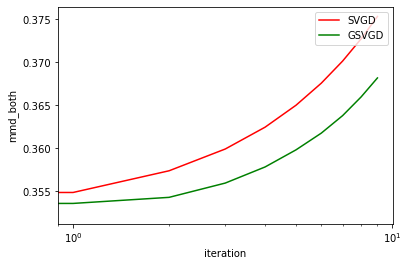

In [21]:
metric_svgd = [s[1] for s in metric_svgd2]
metric_gsvgd = [s[1] for s in metric_gsvgd2]

plt.plot(range(len(metric_svgd)), metric_svgd, color="r", label="SVGD")
plt.plot(range(len(metric_gsvgd)), metric_gsvgd, color="g", label="GSVGD")
plt.xlabel("iteration")
plt.ylabel(metric)
plt.xscale('log')
plt.legend(loc="upper right")

In [56]:
def plot_particles(x_init, x_final, P, d=7.0, step=0.1, concat=None, device="cpu"):
    '''
    Args:
        pad: If in dim > 2, then concat the 2d grid with specified tensor (of 
            shape (1, dim - 2)) when calculating the log likelihood.
    '''
    xv, yv = torch.meshgrid([torch.arange(-d, d, step), torch.arange(-d, d, step)])
    pos_xy = torch.cat((xv.unsqueeze(-1), yv.unsqueeze(-1)), dim=-1)
    if P.event_shape[0] > 2:
        # assert concat is not None, "Need to specify concat in dim larger than 2."
        if concat is None:
            print(("Concatenating higher dims with vector of zeros. Customize by "
                "using the concat argument."))
            concat = torch.zeros((1, P.event_shape[0] - 2))

        pos_xy = torch.cat(
            (pos_xy, concat.repeat(pos_xy.shape[0], pos_xy.shape[1], 1)), 
            dim=2).to(device)
    p_xy = P.log_prob(pos_xy).exp().unsqueeze(-1)
        
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    plt.contourf(xv, yv, p_xy.squeeze(-1))
    plt.scatter(x_init[:, 0], x_init[:, 1], color="r")
    plt.title("Initial")
    plt.subplot(1, 2, 2)
    plt.contourf(xv, yv, p_xy.squeeze(-1))
    plt.scatter(x_final[:, 0], x_final[:, 1], color="r", label="Final")
    plt.title("Final")
    return fig

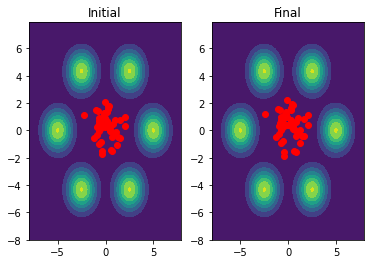

In [57]:
fig = plot_particles(x_init, x, distribution, d=8.0, step=0.1, concat=mix_means[0, 2:], device=device)